---
# Avaliação de Risco de Crédito
---

Este é um projeto que tem como principal objetivo a análise e avaliação de risco de credito, realizado no conjunto de dados de [German Credit Data](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)).

O problema central e análise de crédito dos clientes do banco, que são classificados por `1` igual a um bom crédito e `0` igual a crédito ruim. Com base nos dados é possível encontrar um padrão por meio de um algoritmo de aprendizagem supervisionada (tratando-se básicamente de um problema de classificação). Por meio dos resultados auferidos por esta análise, a área de crédito do banco teria um ponto de partida para sua tomada de decisão sobre conceder ou não crédito aos seus clientes.

Existem 21 atributos no dataset, sendo que o objetivo principal e classificar a variável categórica `credit_rating`:

* `credit_rating` - Rating de crédito, Qualitativa;
* `account_balance` - Saldo da conta, Qualitativa;
* `credit_duration_months` - Duração de meses do crédito;
* `previous_credit_payment_status` - Status de pagamentos anteriores, Qualitativa;
* `credit_purpose` - Objetivo do crédito, Qualitativa;
* `credit_amount` - Valor Total de Crédito Quantitativa;
* `savings` - Poupança, Qualitativa;
* `employment_duration` - Duração do emprego, Qualitativa;
* `installment_rate` - Taxa do empréstimo, Qualitativa;
* `marital_status` - Estado Cívil, Qualitativa;
* `guarantor` - Fiador, Qualitativa;    
* `residence_duration` - Duração no Endereço Atual, Qualitativa;
* `current_assets` - Ativos correntes, Qualitativa;
* `age` - Idade Quantitativa; 
* `other_credits` - Outros créditos, Qualitativa;
* `apartment_type` - Tipo de residência, Qualitativa;
* `bank_credits` - Créditos no banco, Qualitativa;
* `occupation` - Ocupação, Qualitativa; 
* `dependents` - Dependentes, Qualitativa;
* `telephone` - Telefone, Qualitativa;
* `foreign_worker` - Trabalhador estrangeiro, Qualitativa;

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# Pré-processamento e Machine Learning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Métricas
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ClassPredictionError
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# Otimização
import optuna

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

# PEP-8
%load_ext nb_black

/home/bobcasta/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
# Carregando o dataset
df = pd.read_csv('credit_dataset.csv')

# Observando o tipo de cada variável e a sua quantidade de informações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   credit_rating                   1000 non-null   int64
 1   account_balance                 1000 non-null   int64
 2   credit_duration_months          1000 non-null   int64
 3   previous_credit_payment_status  1000 non-null   int64
 4   credit_purpose                  1000 non-null   int64
 5   credit_amount                   1000 non-null   int64
 6   savings                         1000 non-null   int64
 7   employment_duration             1000 non-null   int64
 8   installment_rate                1000 non-null   int64
 9   marital_status                  1000 non-null   int64
 10  guarantor                       1000 non-null   int64
 11  residence_duration              1000 non-null   int64
 12  current_assets                  1000 non-null   int64
 13  age 

<IPython.core.display.Javascript object>

In [3]:
# Observando as 5 primeiras linhas do dataset
df.head()

credit_rating  account_balance  credit_duration_months  \
0              1                1                      18   
1              1                1                       9   
2              1                2                      12   
3              1                1                      12   
4              1                1                      12   

   previous_credit_payment_status  credit_purpose  credit_amount  savings  \
0                               3               2           1049        1   
1                               3               4           2799        1   
2                               2               4            841        2   
3                               3               4           2122        1   
4                               3               4           2171        1   

   employment_duration  installment_rate  marital_status  guarantor  \
0                    1                 4               1          1   
1                    2                 2               3          1   
2                    3                 2               1          1   
3                    2                 3               3          1   
4                    2                 4               3          1   

   residence_duration  current_assets  age  other_credits  apartment_type  \
0                   4               2   21              2               1   
1                   2               1   36              2               1   
2                   4               1   23              2               1   
3                   2               1   39              2               1   
4                   4               2   38              1               2   

   bank_credits  occupation  dependents  telephone  foreign_worker  
0             1           3           1          1               1  
1             2           3           2          1               1  
2             1           2           1          1               1  
3             2           2           2          1               2  
4             2           2           1          1               2

<IPython.core.display.Javascript object>

Podemos obeservar que o dataset é pequeno e possui apenas **1000 linhas**. Além disso podemos perceber que as variáveis que deveriam ser categóricas são do tipo **int64**, vamos transformar estes atributos para o tipo **category** para que se torne mais facil de trabalhar com os mesmos daqui em diante.

In [4]:
# Selecionando as variáveis
cat_vars = ['account_balance', 'previous_credit_payment_status', 'credit_purpose', 
            'savings', 'employment_duration', 'installment_rate', 'marital_status', 
            'guarantor', 'residence_duration', 'current_assets', 'other_credits', 
            'apartment_type', 'bank_credits', 'occupation', 'dependents', 
            'telephone', 'foreign_worker']

# transformando as variáveis para 'category'
for i in cat_vars:
    df[cat_vars] = df[cat_vars].astype('category')

<IPython.core.display.Javascript object>

Pronto, agora podemos plotar os gráficos das variáveis categóricas e assim, olhar mas de perto seus valores. Vamos começar pela variável target `credit_rating`.

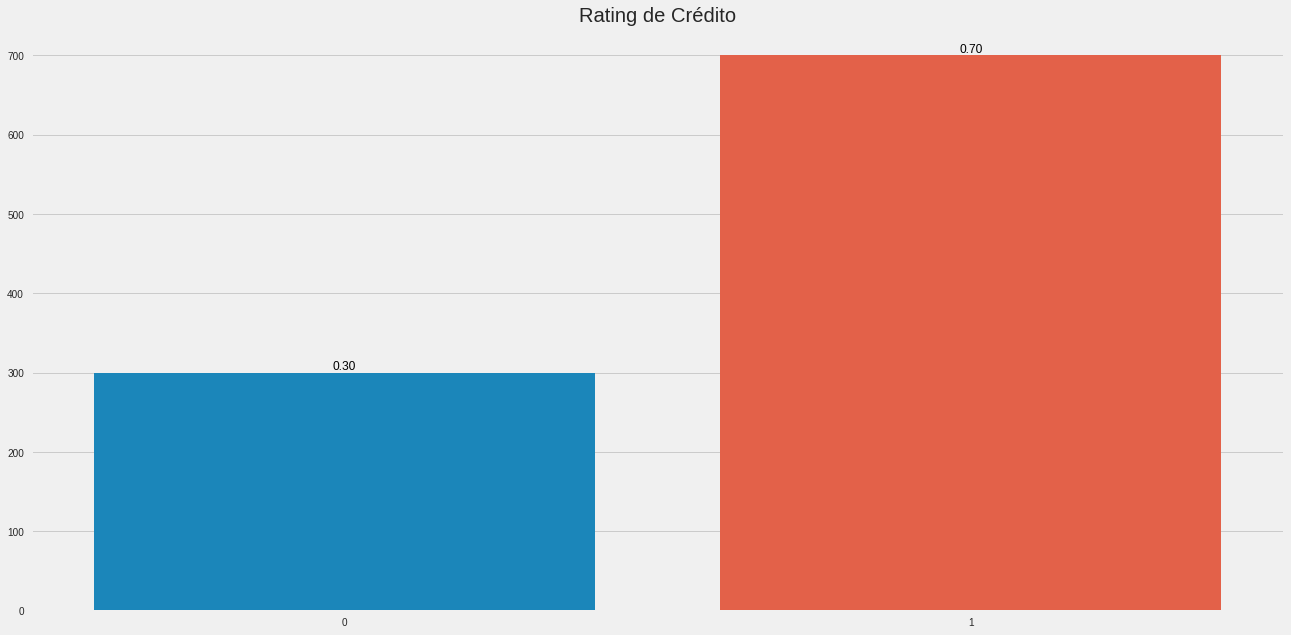

<IPython.core.display.Javascript object>

In [5]:
# Barplot da variável Rating de Crédito
ax = sns.barplot(x=df['credit_rating'].value_counts().index,
                 y=df['credit_rating'].value_counts().values, 
                 data=df)

total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Rating de Crédito')
plt.show()

É bem percetível que a variável alvo está **desbalanceanda** (neste caso em específico se trata de um **over sample**), isso é um problema, pois, ao criar um modelo para tentar avaliar o risco de crédito o mesmo tenderá a prever mais uma classe do que a outra. Porém vamos resolver esse problema mais tarde agora vamos continuar a explorar as demais atributos qualitativos.

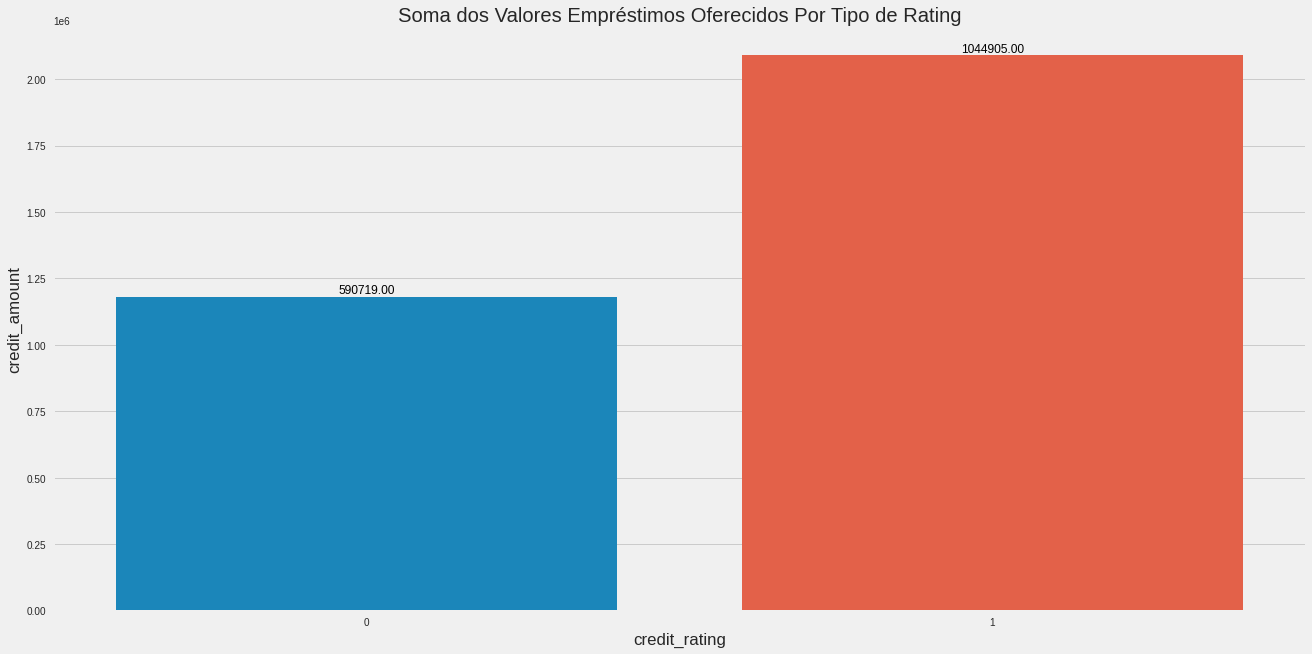

<IPython.core.display.Javascript object>

In [6]:
# Agrupa a soma dos valores por rating e armazena em um DataFrame
loans_values = pd.DataFrame(df.groupby(['credit_rating'])['credit_amount'].sum())

# Barplot da variável Rating de Crédito
ax = sns.barplot(x=loans_values.index,
                 y=loans_values['credit_amount'], 
                 data=df)

total = float(len(loans_values))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Soma dos Valores Empréstimos Oferecidos Por Tipo de Rating')
plt.show()

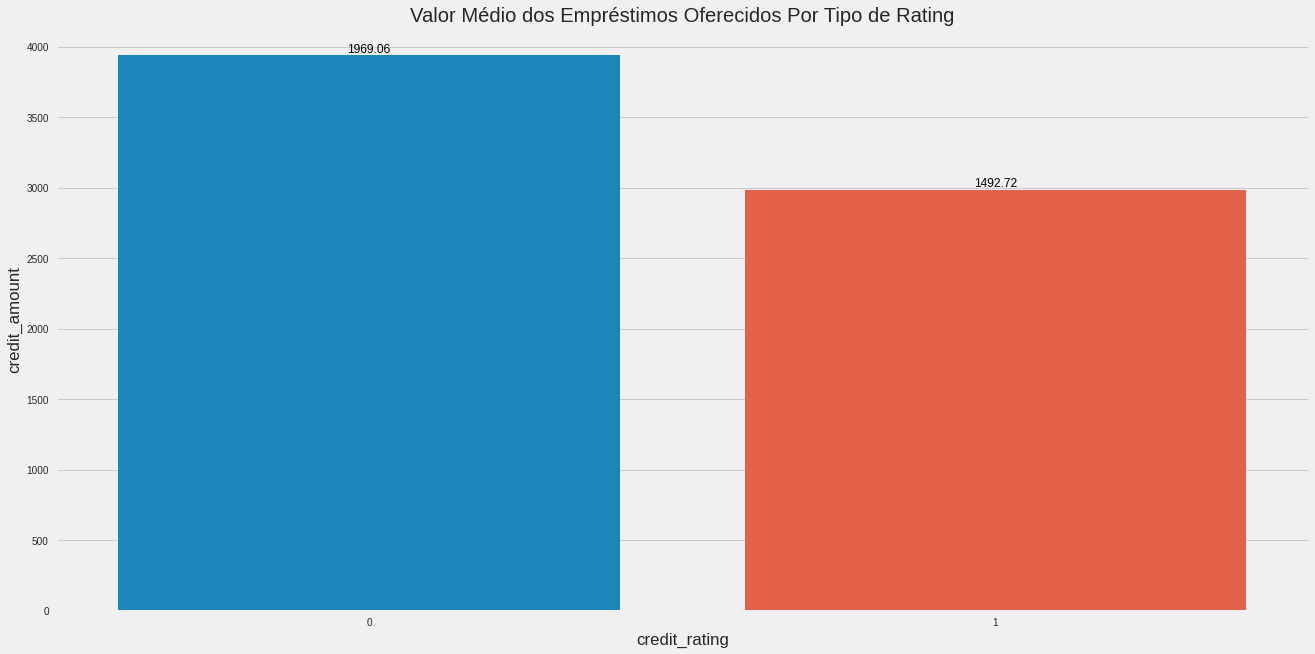

<IPython.core.display.Javascript object>

In [7]:
# Agrupa a soma dos valores por rating e armazena em um DataFrame
loans_values = pd.DataFrame(df.groupby(['credit_rating'])['credit_amount'].mean())

# Barplot da variável Rating de Crédito
ax = sns.barplot(x=loans_values.index,
                 y=loans_values['credit_amount'], 
                 data=df)

total = float(len(loans_values))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Valor Médio dos Empréstimos Oferecidos Por Tipo de Rating')
plt.show()

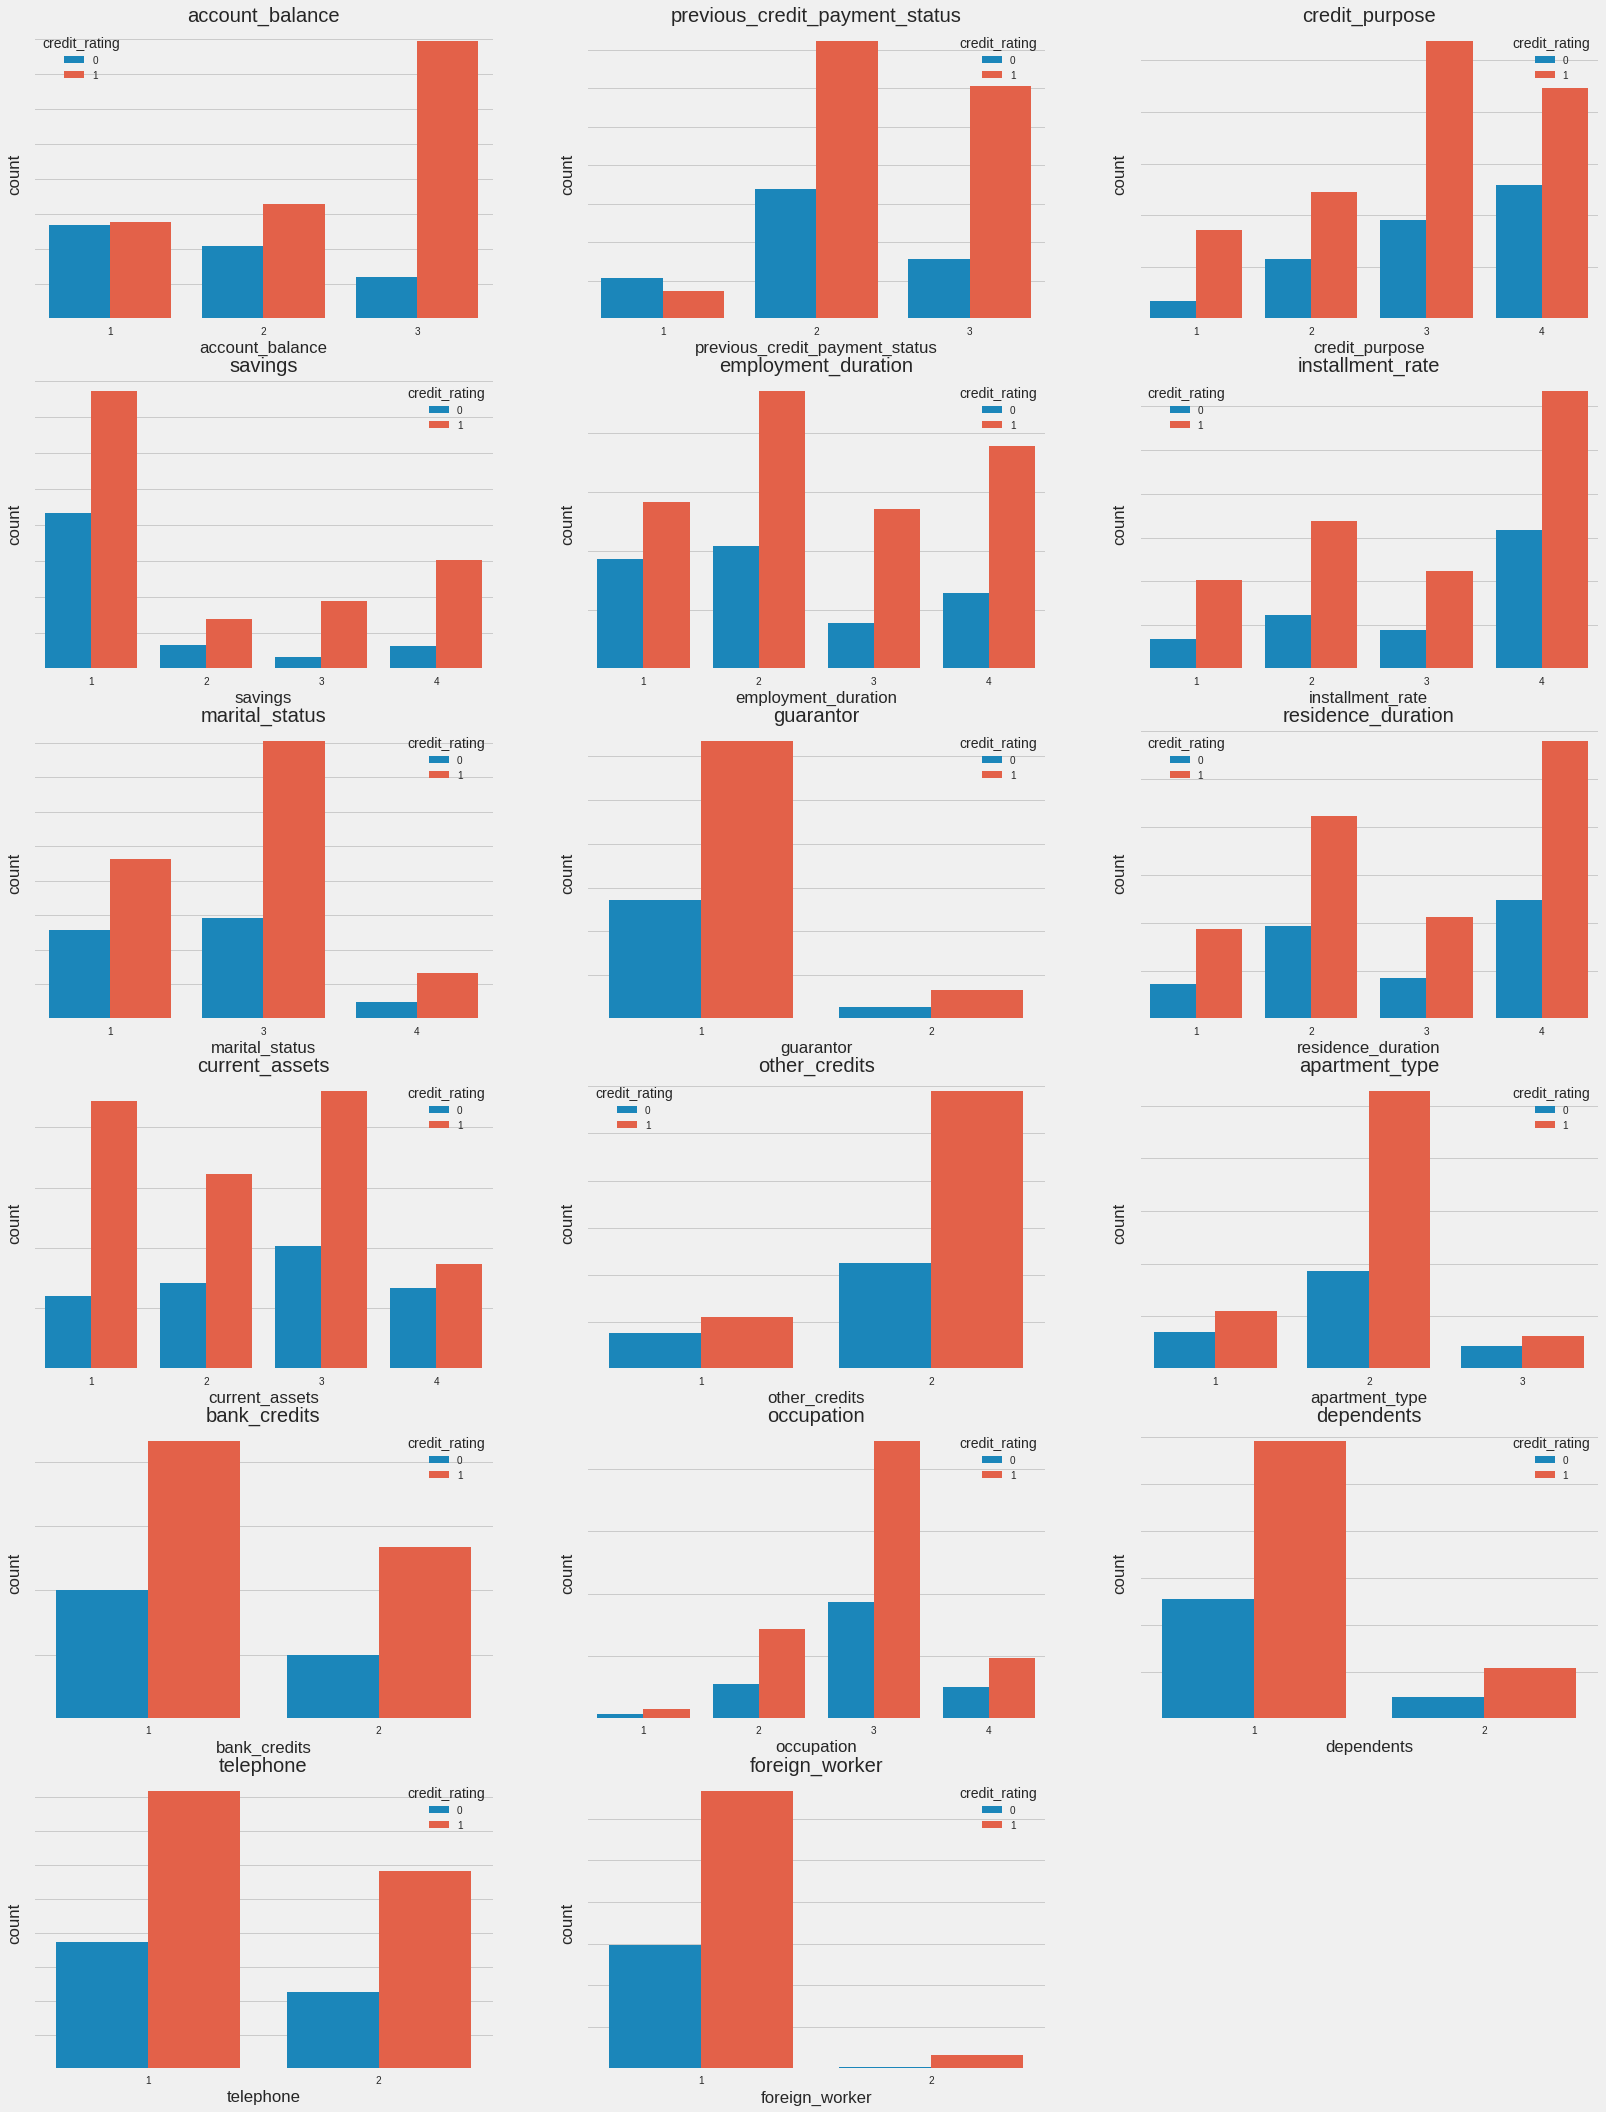

<IPython.core.display.Javascript object>

In [8]:
# Cria um subplot de dimensões 6 x 3
plt.figure(figsize=(25,35))

# Plota um countplot para cada variável segmentados por credito bom é ruim
for idx, col in enumerate(df[cat_vars]):
    ax = plt.subplot(6,3,idx+1)
    ax.yaxis.set_ticklabels([])
    sns.countplot(x=col, data=df, hue='credit_rating') 
    ax.set_title(col)

# Mostra o gráfico
plt.show()

Os gráficos de barras podem mostrar algumas coisas interessantes a respeito das variáveis. No caso o atributo `savings` **mais de 50%** das pessoas que pegaram empréstimos não possuiam nenhum tipo de poupança sendo que destes.A variável `account_balance` para a maioria dos empréstimos realizados são de pessoas que um saldo na conta de **acima de 200 DM** enquanto o restante possui um saldo bancário **0 à 200** sendo estes a maioria das pessoas que possui um crédito ruim no banco.

Dentre os ativos mais valiosos dos clientes `current_assets` **33.4%** é seguro de seguro de vida, sendo que quase **um terço** dos clientes não possui nenhum ativo corrente. Os créditos possuidos no banco `bank_credits` cerca de **2 terços** dos clientes presentes na base de dados possuem **pelo menos 1 tipo de crédito** enquanto os restante dos clientes **possuem mais de um**. Já outros tipos de créditos em outro bancos e estabelecimentos **a grande maioria não possui qualquer outro tipo de crédito** `other_credits`.

Enquanto o atributo `previous_credit_payment_status` status de pagamento anteriores, **mais da metade dos pagamentos de clientes** já estão pagos **53%**.

Dando sequência nos gráficos das variáveis qualitativas. Agora com os atributos `credit_purpose` onde **28%** tem o proposito de compra de um veículo usado ou novo, a grande maioria dos emprestimos feitos pelos clientes, cerca de **um terço** tem como destino o **consumo** enquanto os os restante são classificados com outros tipos. Já as taxas das parcelas `installment_rate` cerca da metade **47.5%** dos clientes possuem taxas **abaixo de 20%** em suas prestações, enquanto os demais possuem taxas **de 20% à acima de 35%**.

Em relação as ocupações dos clientes (variável preditora `occupation`) em sua maioria se declaram como **empregrados especializados, 63%**, cerca de **20%** deles são **residentes não especializados**, outros **15% são executivos** e o restante está **desempregado**. A duração no emprego atual `employment_duration` **40%** destes estão entre **1 à 4 anos** no emprego atual e **30% estão à mais de 7 anos**.

O atributo `foregein_worker` trabalhador estrangeiro, quase todos os clientes que solicitaram créditos mesmo aqueles que possuem crédito ruim são **trabalhadores residentes 96%** sendo o restante em torno de **4% são trabalhadores estrangeiros**.

Quanto ao estado cívil `marital_status` mais da metade dos empréstimos concedidos são para pessoas do **sexo masculino casados 54%**, **36% masculino solteiro** e apenas uma pequena fração de **9% são pessoas do sexo feminino**. A variável `dependents` cerca de **84% dos clientes possuem 3 ou mais dependentes** enquanto o **15%** possuem **apenas 1**. Em `telephone` cerca de **60% dos clientes não possuem telefone** enquanto apenas **40% possui**.

Agora a respeito do tipo de residências dos clientes do banco `apartament_type` **17% dos clientes possuem residências gratuitas**, **10% possuem morádias próprias** e cerca de **70% moram em residências alugadas**. Referente ao tempo que os clientes estão nas suas respectivas residências `residence_duration` a grande maioria **41%** está a **mais de 7 anos** na mesma residência, **30%** esta entre **1 a 4 anos**, **14%** estão entre **4 a 7 anos** e os demais estão em torno de até **1 ano** na mesma residência.

A variável `gurantor` dos clientes presentes nesta base de dados do banco, cerca de **90% possuem fiador**, enquanto os **10% restantes não possuem**. 

Agora vamos continuar a análise exploratória dos dados, porém, nas variáveis quantitativas. No dataset existem apenas 3 atributos quantitivos numericos, sendo eles:

1. Duração de crédito por mês (`credit_duration_months`);

2. Valor total do crédito (`credit_amount`); 

3. Idade (`age`).

Porém antes de passar para uma análise mais aprofundada análise exploratória desses atributos, vamos fazer um pequeno processo de *feature engineering*, onde, com as variáveis quantitativas já existentes criaremos nos variavéis que podem trazerem melhores resultados nos modelos que serão treinados mais adiante.

In [9]:
# Criando a nova variável 'amount_per_age', Quantidade do empréstimo por idade
df['amount_per_age'] = df['credit_amount'] / df['age']

# Criando a nova variável 'amount_per_months', Quantidade do empréstimo por meses
df['amount_per_months'] = df['credit_amount'] / df['credit_duration_months']

# Criando a nova variável 'duration_per_age', Duração do empréstimo pela idade
df['duration_per_age'] = df['age'] / df['credit_duration_months']

<IPython.core.display.Javascript object>

In [10]:
# Resumo estatístico das variáveis quantitativas
quant_vars = ['credit_duration_months', 'credit_amount', 'age', 
              'amount_per_age', 'amount_per_months', 'duration_per_age']

df[quant_vars].describe()

credit_duration_months  credit_amount         age  amount_per_age  \
count             1000.000000     1000.00000  1000.00000     1000.000000   
mean                20.903000     3271.24800    35.54200       99.496231   
std                 12.058814     2822.75176    11.35267       91.260661   
min                  4.000000      250.00000    19.00000        6.097561   
25%                 12.000000     1365.50000    27.00000       40.097147   
50%                 18.000000     2319.50000    33.00000       68.626190   
75%                 24.000000     3972.25000    42.00000      128.424643   
max                 72.000000    18424.00000    75.00000      745.380952   

       amount_per_months  duration_per_age  
count        1000.000000       1000.000000  
mean          167.685413          2.409029  
std           153.492003          1.856459  
min            24.055556          0.333333  
25%            89.331250          1.166667  
50%           130.333333          1.833333  
75%           206.183333          3.058333  
max          2482.666667         14.800000

<IPython.core.display.Javascript object>

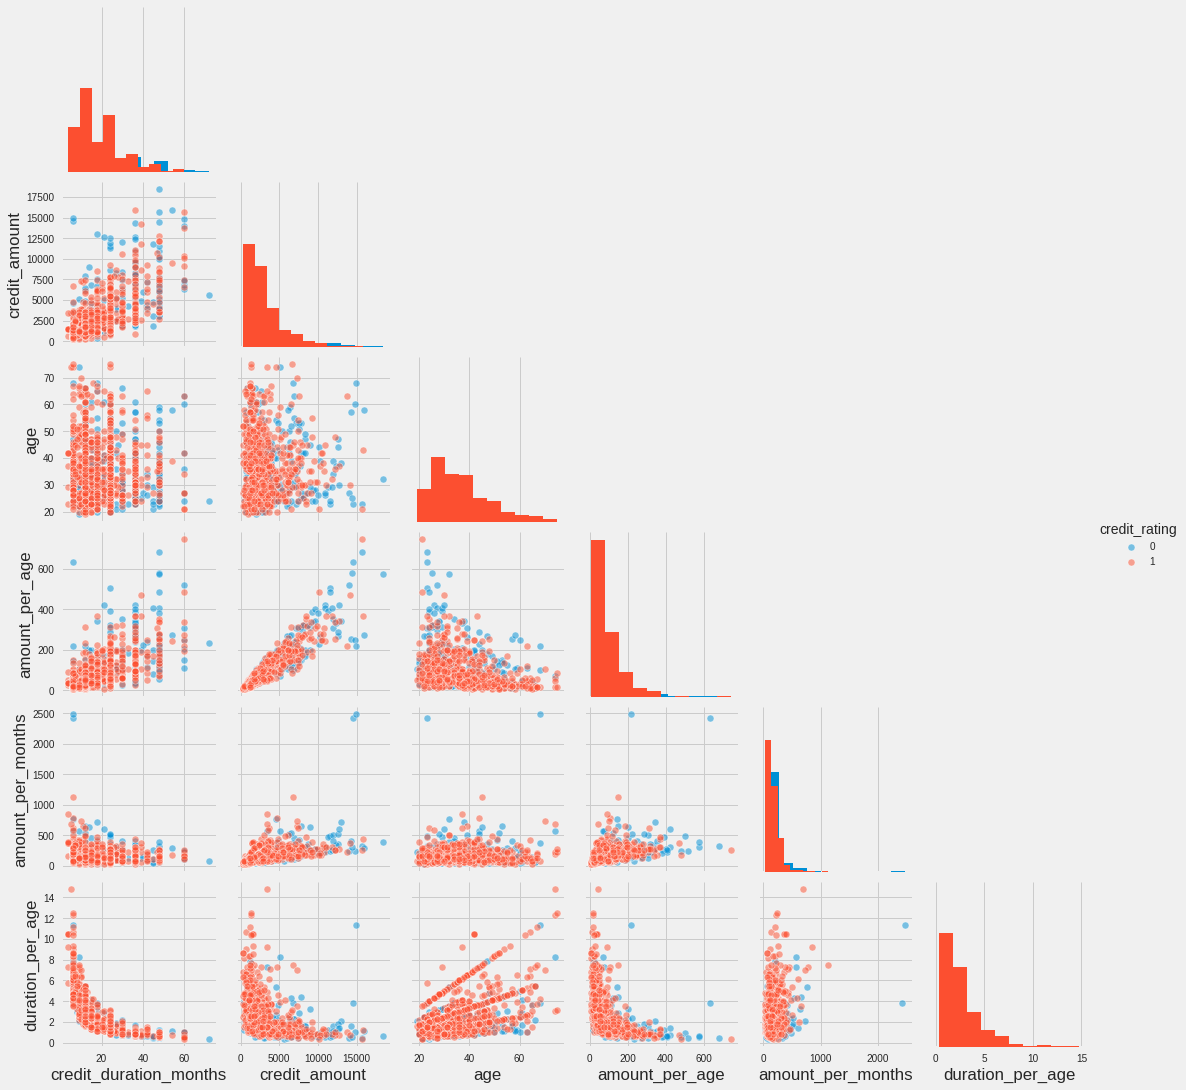

<IPython.core.display.Javascript object>

In [11]:
# Visualizando as relações entre as novas variáveis quantitativas através de gráfico dispersão
sns.pairplot(df, 
             vars=df[quant_vars], 
             hue='credit_rating', 
             diag_kind='hist', 
             corner=True, 
             plot_kws=dict(alpha=0.5))

plt.show()

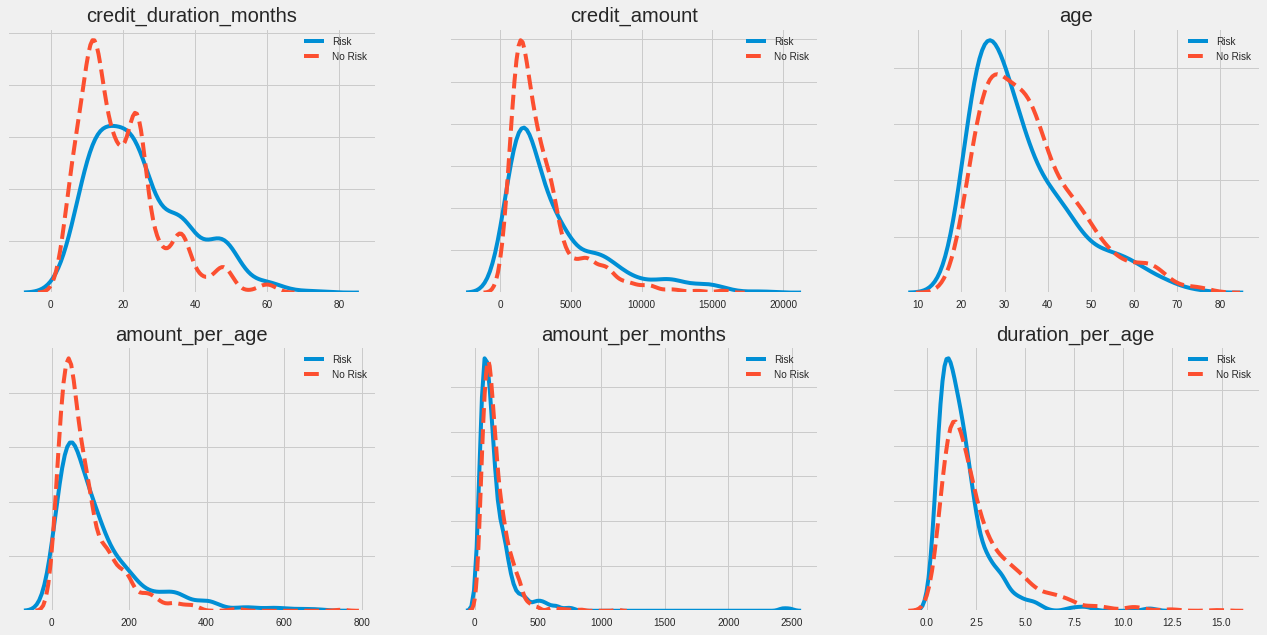

<IPython.core.display.Javascript object>

In [12]:
# Cria um subplot de dimensões 3 x 3

# Plota um gráfico de densidade para cada variável segmentados por com e sem risco
for idx, col in enumerate(df[quant_vars]):
    ax = plt.subplot(2,3,idx+1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(df.loc[df.credit_rating == 0][col], hist=False, axlabel= False, 
    kde_kws={'linestyle':'-', 
             'label':"Risk"})
    sns.distplot(df.loc[df.credit_rating == 1][col], hist=False, axlabel= False, 
    kde_kws={'linestyle':'--', 
             'label':"No Risk"})
    ax.set_title(col)

# Mostra o gráfico
plt.show()

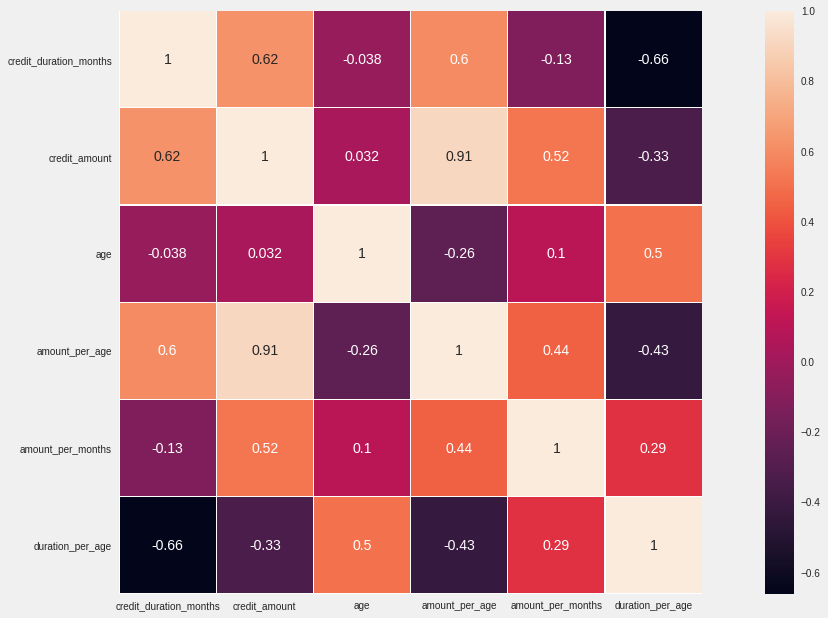

<IPython.core.display.Javascript object>

In [13]:
# Cria uma matrix de correlação dos atributos quantitativos
sns.heatmap(df[quant_vars].corr(method='pearson'), 
            annot=True, 
            linewidths=0.3, 
            square=True)

# Mostra o gráfico
plt.show()

As novas variáveis criadas também parecem apresentar um certo grau de correlação entre elas, assim como, as aprensentadas anteriormente, porém com maior intensidade. Além do mais elas são muito mais assimétricas do que as outras que foram usadas para criá-las.

Mais adiante investigaremos essa assimétria e a corrigirimos para que possamos aplicar os algoritmos de aprendizado de máquina supervisona. Porém antes disso, vamos olhar para todas as variáveis quantitativas e inspecionar se elas possuem outliers, tratar os mesmos, para que podermos ter melhores resultados nos modelos, para isso, vamos olhar os box-plots das variáveis.

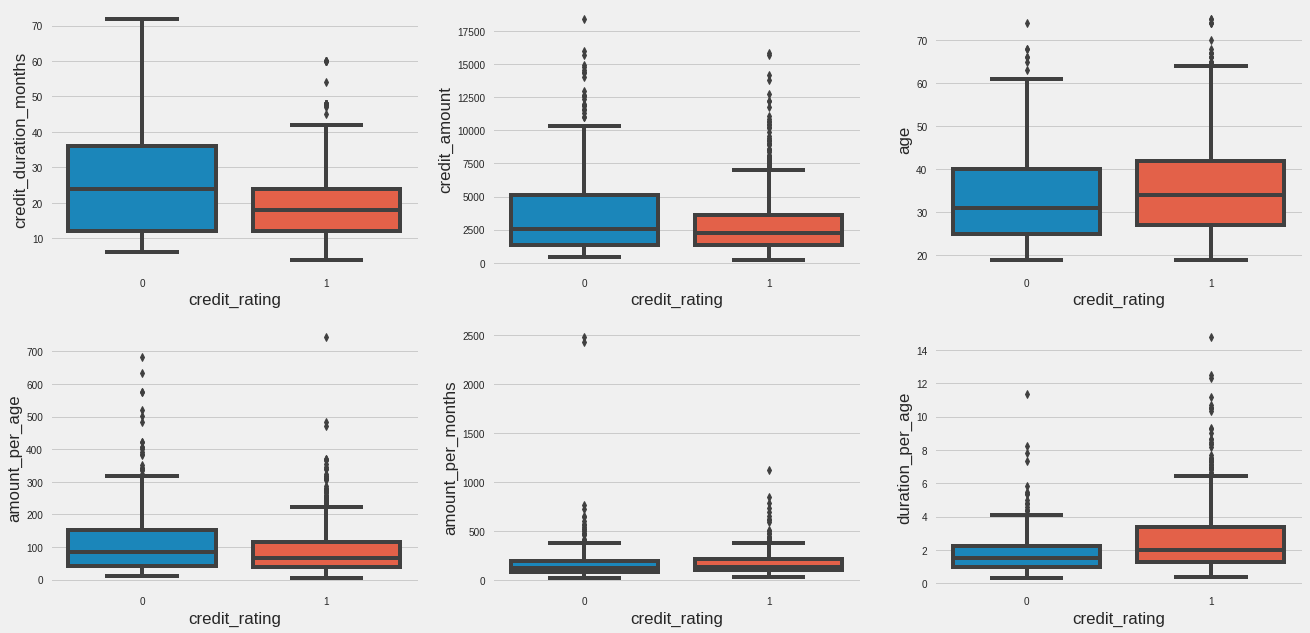

<IPython.core.display.Javascript object>

In [14]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o box plot
for ax, box in zip(axes, df[quant_vars]):
    sns.boxplot(x='credit_rating',
                y=box, 
                ax=ax,
                data=df)

# Mostra o gráfico
plt.show()

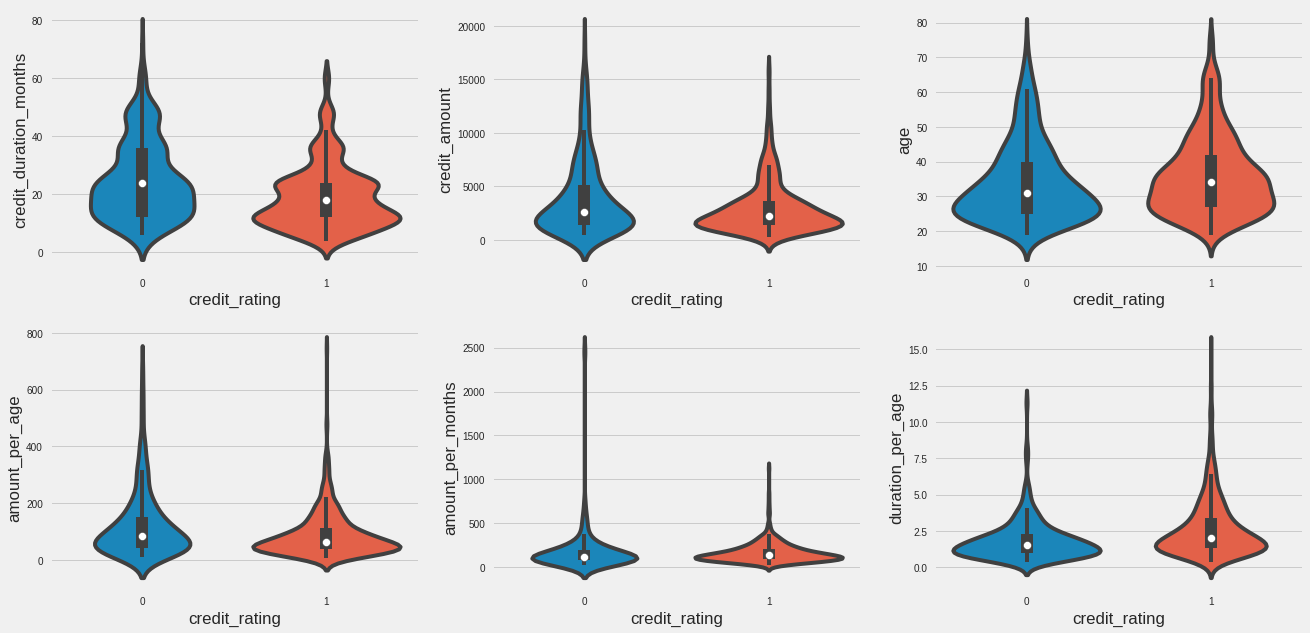

<IPython.core.display.Javascript object>

In [15]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o violin plot
for ax, violin in zip(axes, df[quant_vars]):
    sns.violinplot(x='credit_rating',
                   y=violin, 
                   ax=ax,
                   split=True,
                   data=df)

# Mostra o gráfico
plt.show()

Pelos gráficos apresentados é bem visível que todos os atributos quantitativos possuem *outliers*, isso é ruim, pois quando formos treinar modelos de *machine learning*. Muitas vezes os modelos utilizados são sensiveis a *outliers* e com a presença deles o tempo de treinamento tende a ser maior, eles tendem a ser menos precisos, pois eles estão aprendendo o ruído contido nos dados, resultando em resultados ruins.

Muitas vezes os outliers tendem a serem removidos por dos dados, porém, como o dataset possui poucos dados, (apenas 1000) optei por ser parcimonioso substituir os *outliers* existentes pelo os **95º quantil** de cada variável do conjunto de dados, e assim não retirar os dados do dataset.

In [16]:
# Selecionando o 95º quantil das variáveis
upper_quantiles = df[['credit_duration_months', 'credit_amount', 'age', 
                      'amount_per_months', 'amount_per_age', 'duration_per_age']].quantile(.95)
upper_quantiles

credit_duration_months      48.000000
credit_amount             9162.700000
age                         60.000000
amount_per_months          363.573397
amount_per_age             278.647632
duration_per_age             6.166667
Name: 0.95, dtype: float64

<IPython.core.display.Javascript object>

In [17]:
# Selecionando os dados que são maiores que o 95º quantil
outliers_upper = (df[['credit_duration_months', 'credit_amount', 'age', 
                      'amount_per_months', 'amount_per_age', 'duration_per_age']] > upper_quantiles)

<IPython.core.display.Javascript object>

In [18]:
# Substituindo os outliers pelo 95º quantil de cada variável
outliers = ['credit_duration_months', 'credit_amount', 'age',
            'amount_per_months', 'amount_per_age', 'duration_per_age']

for i in outliers:
    df[outliers] = df[outliers].mask(outliers_upper, upper_quantiles, axis=1)

<IPython.core.display.Javascript object>

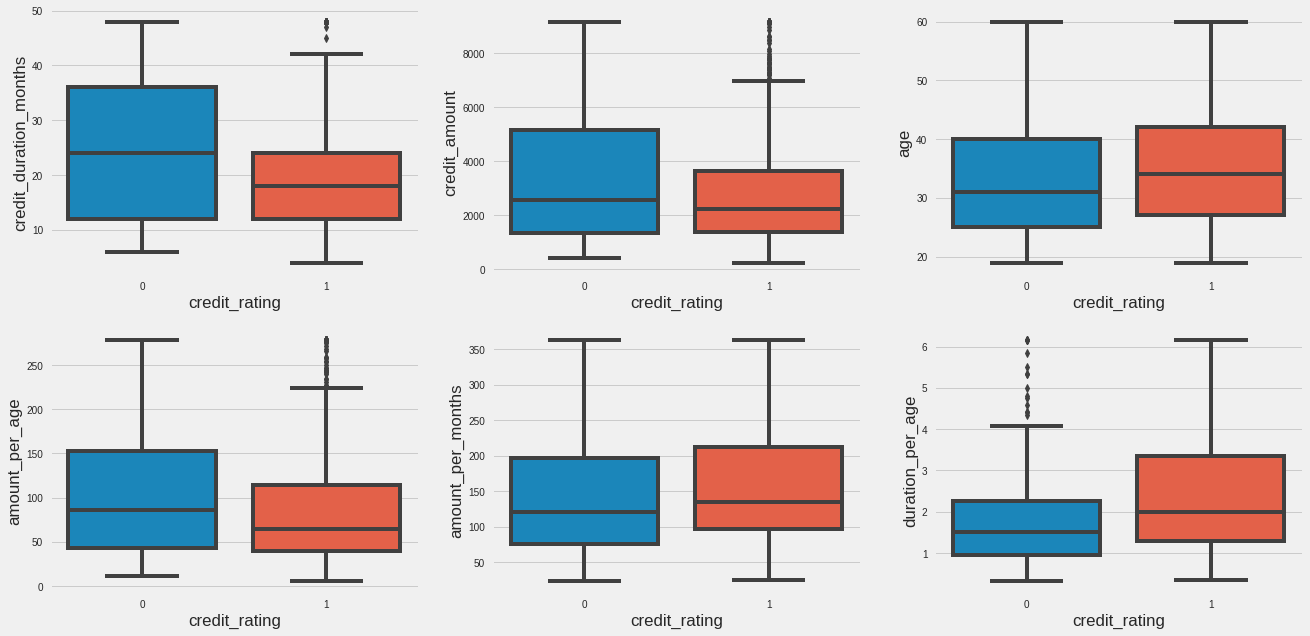

<IPython.core.display.Javascript object>

In [19]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o box plot
for ax, box in zip(axes, df[quant_vars]):
    sns.boxplot(x='credit_rating',
                y=box, 
                ax=ax,
                data=df)

# Mostra o gráfico
plt.show()

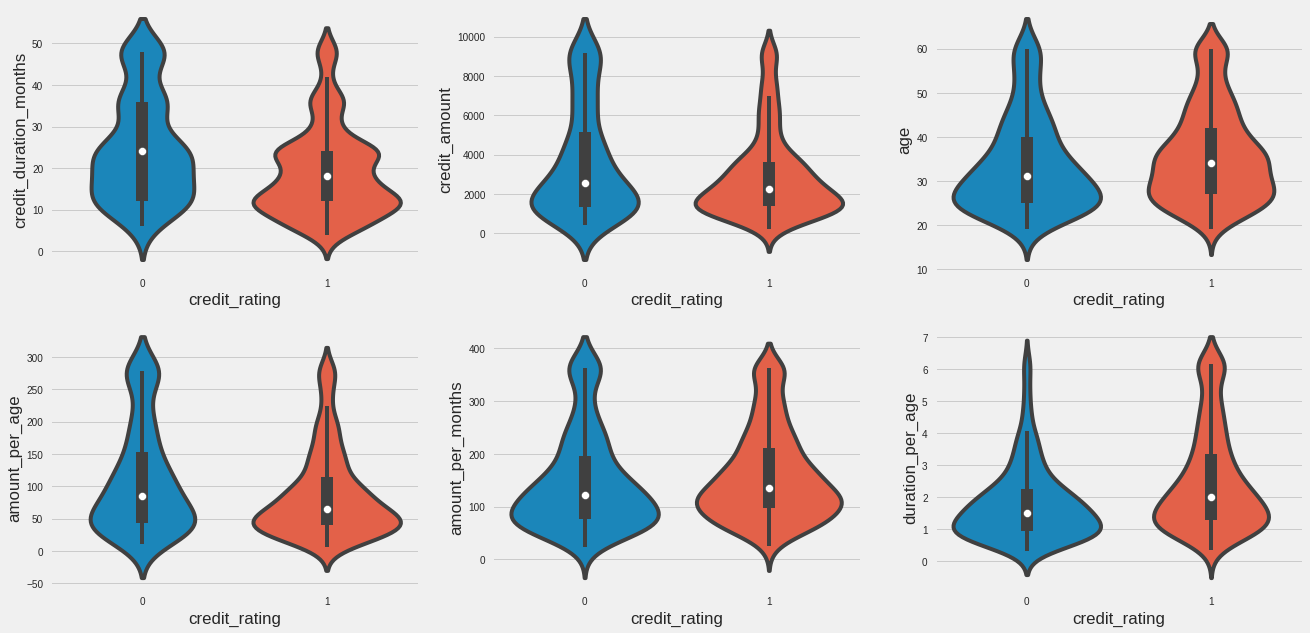

<IPython.core.display.Javascript object>

In [20]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o violin plot
for ax, violin in zip(axes, df[quant_vars]):
    sns.violinplot(x='credit_rating',
                   y=violin, 
                   ax=ax,
                   split=True,
                   data=df)

# Mostra o gráfico
plt.show()

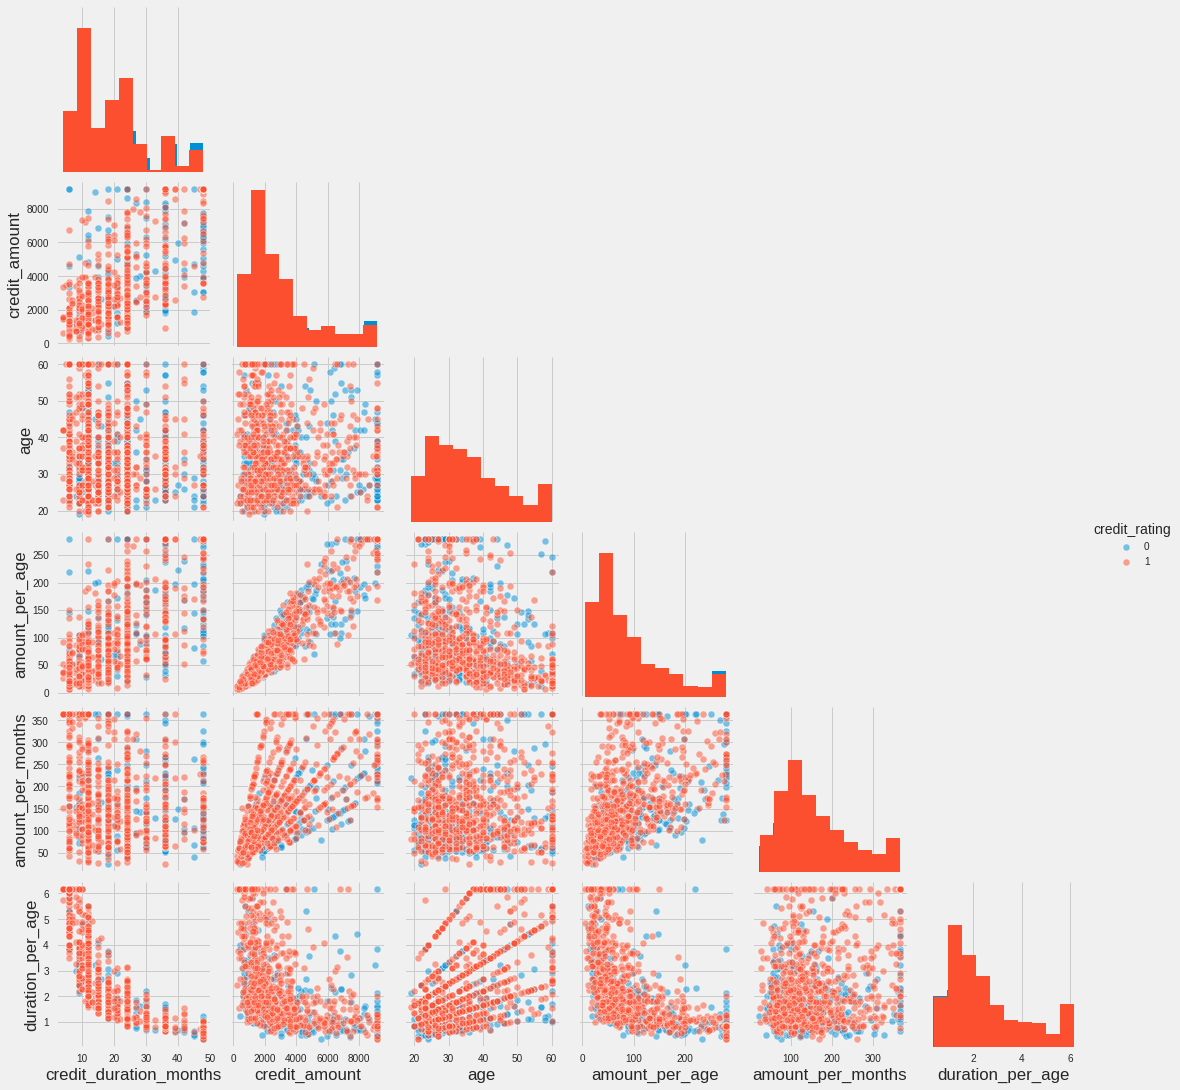

<IPython.core.display.Javascript object>

In [21]:
# Visualizando as relações entre as novas variáveis quantitativas através de gráfico dispersão
sns.pairplot(df, 
             vars=df[quant_vars], 
             hue='credit_rating', 
             diag_kind='hist', 
             corner=True,
             plot_kws=dict(alpha=0.5))

plt.show()

Os *outliers* presentes nas variáveis foram quase todos substítuidos, por meio do método utilizado, exato por quatro atributos, porém como disse anteriormente optei por ser parcimonioso, pelos gráficos de dispersão e possível ver que a menos *outliers* do que anteriormente.

Agora vamo partir para a análise da assimetria das variáveis quantitativas, vamos primeiro olhar para essa medida e logo após, vamos olhar para um *probplot* desses atributos para ver se os mesmos possuem uma **distribuição norma**l para que possamos aplicar os algoritmos de *machine learning*. 

In [22]:
# Assimentria das variáveis quantitativas
df[['credit_duration_months', 'credit_amount', 'age', 
    'amount_per_months', 'amount_per_age', 'duration_per_age']].skew()

credit_duration_months    0.871721
credit_amount             1.228174
age                       0.778506
amount_per_months         0.921506
amount_per_age            1.192597
duration_per_age          1.152794
dtype: float64

<IPython.core.display.Javascript object>

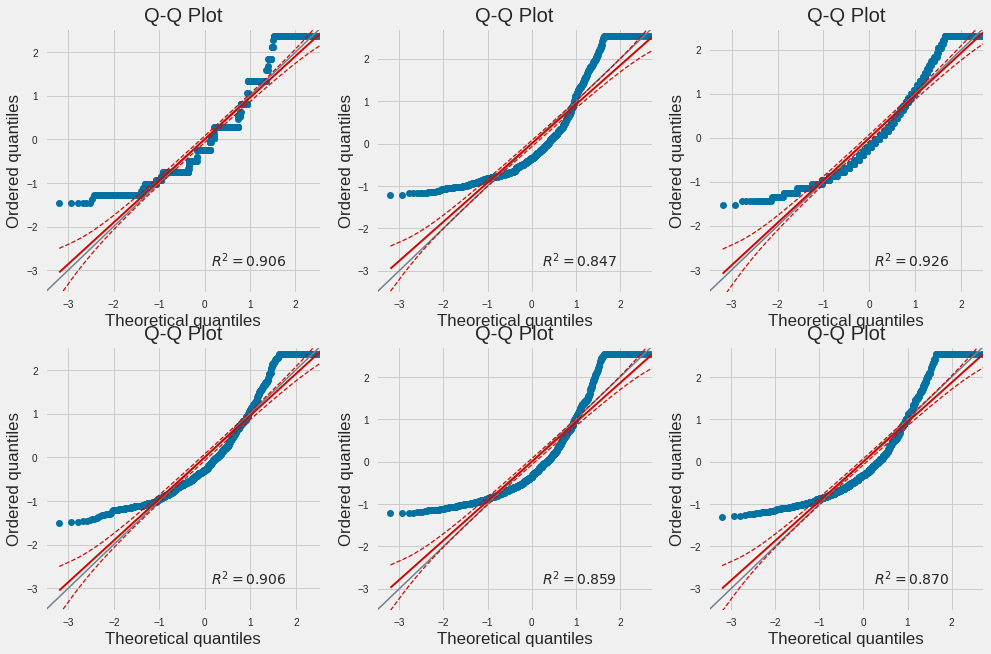

<IPython.core.display.Javascript object>

In [23]:
# Cria um Q-Q plot utilizando a biblioteca pingouin
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1 = pg.qqplot(df['credit_duration_months'], dist='norm', ax=ax1)
ax2 = pg.qqplot(df['credit_amount'], dist='norm', ax=ax2)
ax3 = pg.qqplot(df['age'], dist='norm', ax=ax3)
ax4 = pg.qqplot(df['amount_per_months'], dist='norm', ax=ax4)
ax5 = pg.qqplot(df['amount_per_age'], dist='norm', ax=ax5)
ax6 = pg.qqplot(df['duration_per_age'], dist='norm', ax=ax6)

plt.show()

Como dito anteriomente as variáveis quantittivas do dataset possuem uma **assimetria positiva** e não se adequam a **curva guassiana** algo ruim pois certos modelos de aprendizado de máquina esperam que os dados apresentados estejam normalizados. Para tanto, vamos usar o *PowerTransformer* do *Scikit Learn* para que possamos resolver este problema, mas primeiramente vamos concatenar os dois tipos de variáveis e então aplicar tais tranformações por meio de um pipeline.

Antes de começar vamos dividir o conjunto de dados em treino e teste para poder avaliar como os modelos se saíram em dados nunca vistos.

In [24]:
# Separa as variáveis preditoras da variável target
X = df.drop('credit_rating', axis=1)
y = df['credit_rating']

# Divide o conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

<IPython.core.display.Javascript object>

Tudo pronto, agora podemos partir para a parte de criação e escolha dos modelos de **aprendizado de máquina**. Vamos treinar vários modelos de inicio e escolher o modelo que possui o maior ***ROCAUC Score*** pois como possuimos um dataset com classes desbalanceadas ele o ***ROCAUC Score*** passa a ser uma bom métrica. Em seguida, após vamos refinar o ajuste do modelo escolhido, por meio de ***Otimização Bayessiana***.

DummyClassifier(): 0.460270 (0.048295)
DecisionTreeClassifier(random_state=42): 0.609532 (0.061918)
RandomForestClassifier(random_state=42): 0.784794 (0.063997)
ExtraTreesClassifier(random_state=42): 0.775661 (0.060545)
AdaBoostClassifier(random_state=42): 0.753379 (0.065924)
GradientBoostingClassifier(random_state=42): 0.780444 (0.075313)
HistGradientBoostingClassifier(random_state=42): 0.763778 (0.071623)


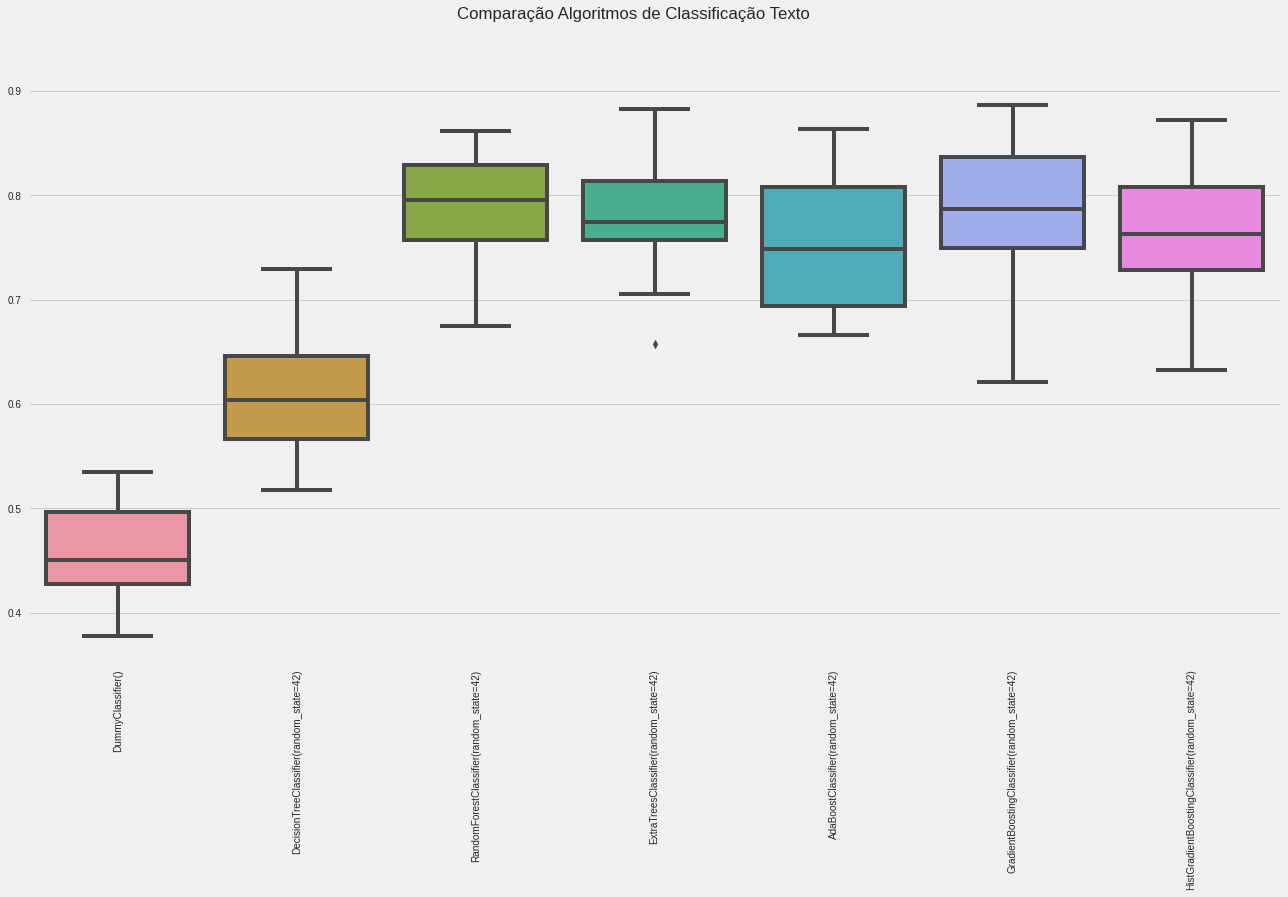

<IPython.core.display.Javascript object>

In [25]:
# Transformando as colunas do dataset
preprocessor = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), cat_vars), 
                                               ('power', PowerTransformer(method='yeo-johnson'), quant_vars)])

# Lista com os modelos utilizados
models = [DummyClassifier(),
          DecisionTreeClassifier(random_state=42), 
          RandomForestClassifier(random_state=42),
          ExtraTreesClassifier(random_state=42),
          AdaBoostClassifier(random_state=42),
          GradientBoostingClassifier(random_state=42),
          HistGradientBoostingClassifier(random_state=42)]

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor pipeline por meio de uma validação cruzada
for i, model in enumerate(models):
    
    # Pipeline contendo pré-processamento e os modelos utilizados
    full_pipeline = Pipeline([('preprocessor', preprocessor), 
                              ('model', model)])
    
    # Validação Cruzada
    cv_results = cross_val_score(full_pipeline, X_train, y_train, cv=10, scoring='roc_auc')
    
    # Armazena cada resultado obtidos em um lista
    resultados.append(cv_results)
    
    # Armazena cada nome dos modelos em uma lista
    nomes.append(model)
    
    # Printa o ROCAUC médio de cada modelo 
    msg = '%s: %f (%f)' % (model, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot para comparação entre os modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Classificação Texto')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Conforme apresentado pelo gráfico anterior o modelo que apresentou o melhor desempenho foi o ***Random Forest Classifier***. Sendo assim agora vamos otimizar este modelo, para isso vamos utilizar duas técnicas, primeiro vamos definir os hiperparâmetros a serem utilizados e depois aplicar ***Otimização Bayessiana*** por meio de ***Processos Guassianos*** para escolher uma faixa de hiperparâmetros.

In [26]:
# Cria a função de otimização
def objective(trial):
    
    # Define os espaços de hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'max_depth': trial.suggest_int('max_depth', 5, 25), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5), 
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 25),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    # Preprocessamento das variáveis categóricas e quantitivas
    preprocessor = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), cat_vars), 
                                                   ('power', PowerTransformer(method='yeo-johnson'), quant_vars)])

    
    # Pipeline com preprocessamento e LogisticRegression
    model = Pipeline([('preprocessor', preprocessor),
                      ('Random_Forest', RandomForestClassifier(**params, 
                                                               oob_score=True,
                                                               random_state=42))])
    
    # Retorna a acurácia otbida na validação cruzada
    return np.mean(cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc'))

<IPython.core.display.Javascript object>

In [27]:
# Otimização dos hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2020-09-06 21:37:26,277] Trial 0 finished with value: 0.7848355295237986 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7848355295237986.
[I 2020-09-06 21:37:36,281] Trial 1 finished with value: 0.7837550267615895 and parameters: {'n_estimators': 629, 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 16, 'max_features': 'log2'}. Best is trial 0 with value: 0.7848355295237986.
[I 2020-09-06 21:37:40,784] Trial 2 finished with value: 0.7923200261592386 and parameters: {'n_estimators': 261, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7923200261592386.
[I 2020-09-06 21:37:48,231] Trial 3 finished with value: 0.7855194846171056 and parameters: {'n_estimators': 422, 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 23, 'max_features': 'auto'}. Best is trial 2 with value: 0.792320026159

<IPython.core.display.Javascript object>

In [28]:
# Imprime os resultados da otimização
print('The Bests Parameters are: ', study.best_params)
print('The Best Score Value is: ', study.best_value)
print('The Best Trial is: ', study.best_trial)

The Bests Parameters are:  {'n_estimators': 261, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_features': 'sqrt'}
The Best Score Value is:  0.7923200261592386
The Best Trial is:  FrozenTrial(number=2, value=0.7923200261592386, datetime_start=datetime.datetime(2020, 9, 6, 21, 37, 36, 285067), datetime_complete=datetime.datetime(2020, 9, 6, 21, 37, 40, 783727), params={'n_estimators': 261, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_features': 'sqrt'}, distributions={'n_estimators': IntUniformDistribution(high=1200, low=100, step=1), 'max_depth': IntUniformDistribution(high=25, low=5, step=1), 'min_samples_leaf': IntUniformDistribution(high=5, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=25, low=5, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE)


<IPython.core.display.Javascript object>

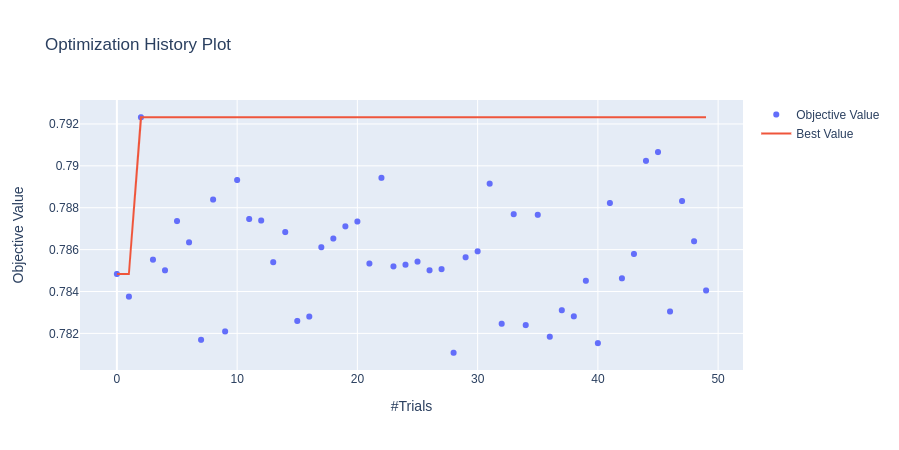

<IPython.core.display.Javascript object>

In [29]:
# Gráfico com a trajetória de otimização
optuna.visualization.plot_optimization_history(study)

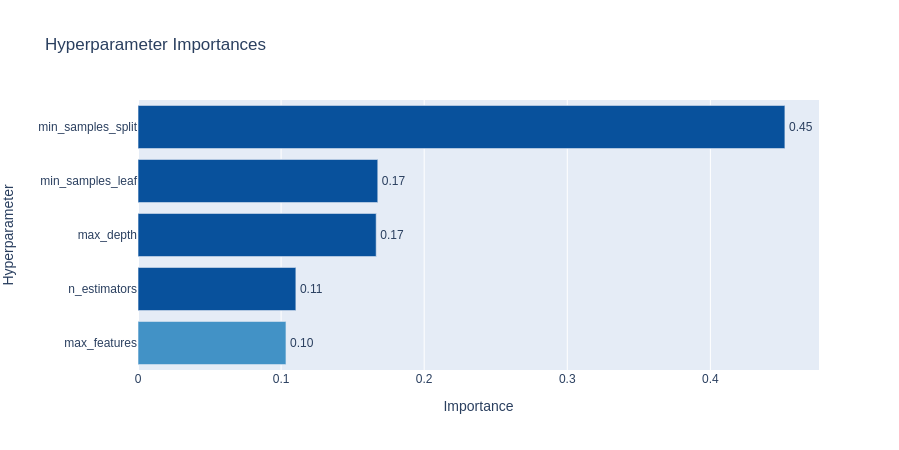

<IPython.core.display.Javascript object>

In [30]:
# Gráfico com a importância dos parâmetros
optuna.visualization.plot_param_importances(study)

Agora que sabemos o ajuste dos hiperparâmetros, podemos treinar o modelo de Floresta Aleatória e depois validado por meio da curva de validação e a curva de aprendizagem.

In [31]:
# Preprocessamento das variáveis categóricas e quantitivas
preprocessor = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), cat_vars), 
                                               ('power', PowerTransformer(method='yeo-johnson'), quant_vars)])

rf_cfl = RandomForestClassifier(n_estimators=261, 
                                max_depth=14, 
                                min_samples_leaf=1, 
                                min_samples_split=12, 
                                max_features='sqrt',
                                oob_score=True, 
                                random_state=42)

# Pipeline com preprocessamento e LogisticRegression
model = Pipeline([('preprocessor', preprocessor),
                  ('Random_Forest', rf_cfl)])


model.fit(X_train, y_train)

pred = model.predict(X_test)

<IPython.core.display.Javascript object>

Uma curva de aprendizado mostra a relação da pontuação do treinamento versus a pontuação do teste validado cruzado para um estimador com um número variável de amostras de treinamento. Por meio dessa curva de aprendizado e possível ver que o modelo se beneficiaria se mais dados fossem inseridos com as curvas ainda não convergiram e a curva da validação cruzada a partir de 700 passa a ter uma tendência ascendente.

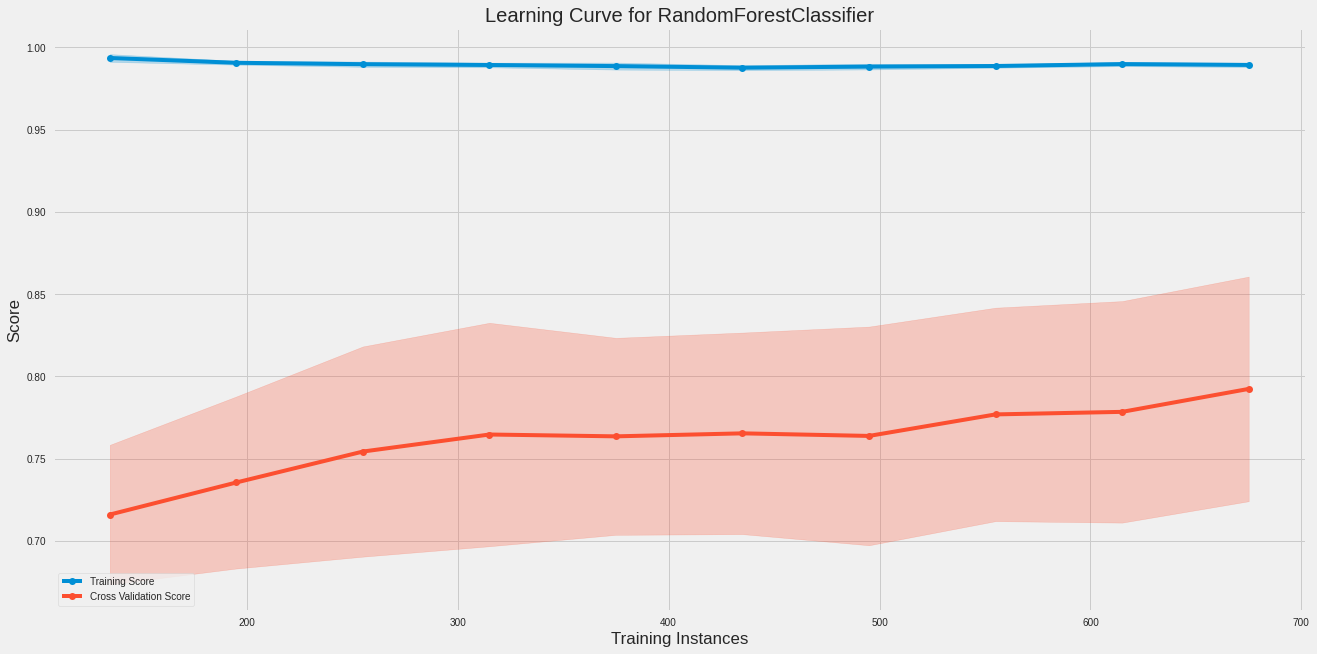

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

<IPython.core.display.Javascript object>

In [32]:
# Cria a divisão dos dados
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.2, 1.0, 10)

# Instanciando o modelo de Regressão e o visualizador
visualizer = LearningCurve(model, 
                           cv=cv, 
                           scoring='roc_auc', 
                           train_sizes=sizes, 
                           n_jobs=4)

# Ajuste os dados de treinamento ao visualizador
visualizer.fit(X_train, y_train)

# Plota os scores da validação cruzada
visualizer.show()

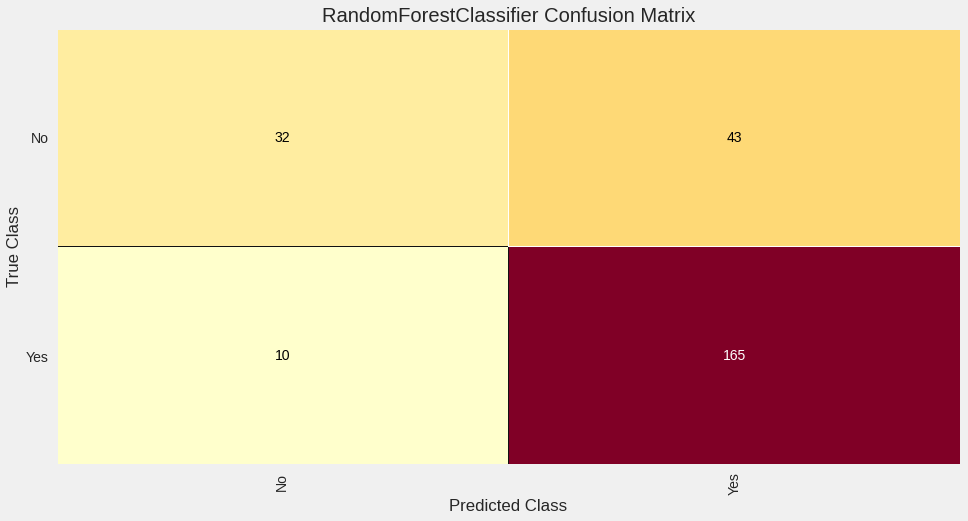

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

<IPython.core.display.Javascript object>

In [33]:
# Apresentando o modelo para ConfusionMatrix
conf_matrix = ConfusionMatrix(model, 
                              classes=['No', 'Yes'], 
                              size=(1040, 540))

# Treina o modelo
conf_matrix.fit(X_train, y_train)

# Apresentando os dados de teste para a ConfusionMatrix
conf_matrix.score(X_test, y_test)

# Plot a Matriz de Confusão
conf_matrix.show()

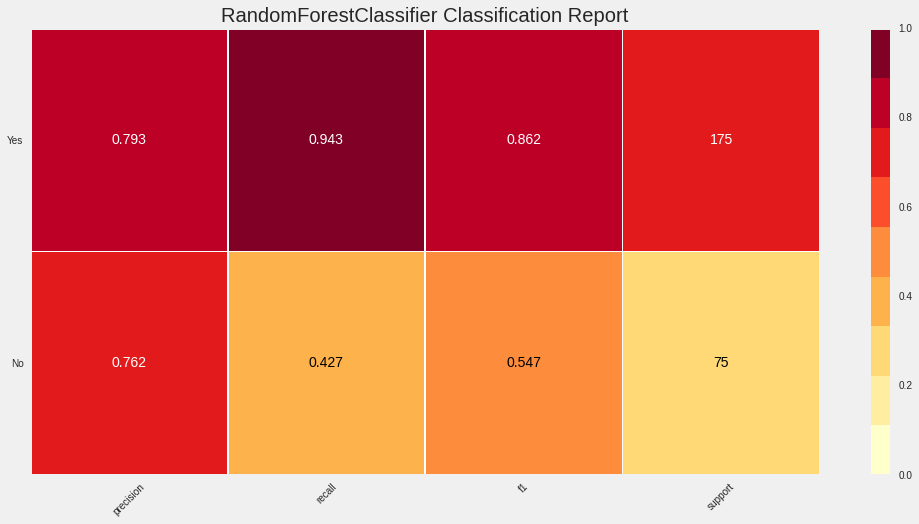

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

<IPython.core.display.Javascript object>

In [34]:
# Apresentando o modelo para ConfusionMatrix
clf_report = ClassificationReport(model, 
                                  classes=["No", "Yes"], 
                                  support=True, 
                                  size=(1040, 540))

# Treina o modelo
clf_report.fit(X_train, y_train)

# Apresentando os dados de teste para a ClassificationReport
clf_report.score(X_test, y_test)

# Plota o Relatório de classificação
clf_report.show()

Este é uma das melhores métricas quando se possuem **classes desbalanceadas**, pois ela é **incensível a classes desbalanceadas**, ela é uma medida da qualidade preditiva de um classificador que compara e visualiza a troca entre a sensibilidade e especificidade do modelo.

Quanto mais a esquerda melhor, pois, quanto mais a esquerda os falsos positivos são zero e os verdadeiros positivos são um, pois quanto maior a inclinação da curva, pois isso descreve a maximização da taxa positiva verdadeira e minimiza a taxa positiva falsa.

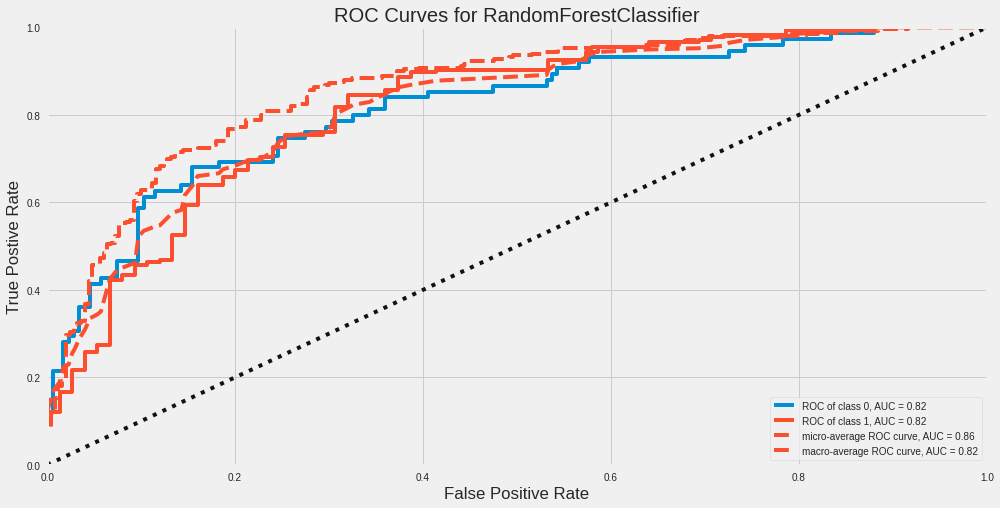

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

<IPython.core.display.Javascript object>

In [35]:
# Instanciando a curva ROCAUC
rocauc = ROCAUC(model, 
                size=(1080, 540))

# Ajuste os dados de treinamento ao visualizador
rocauc.fit(X_train, y_train)

# Avalie o modelo nos dados de teste
rocauc.score(X_test, y_test)

# Plota da curva ROCAUC
rocauc.show()

Uma curva de aprendizado mostra a relação da pontuação do treinamento versus a pontuação do teste validado cruzado para um estimador com um número variável de amostras de treinamento. Por meio dessa curva de aprendizado e possível ver que o modelo se beneficiaria se mais dados fossem inseridos com as curvas ainda não convergiram e a curva da validação cruzada a partir de 700 passa a ter uma tendência ascendente.